In [1]:
import numpy as np
import matplotlib.pyplot as plt
from generate_magnetic_field import get_mag_field
from create_poly_lib import get_poly_lib

In [2]:
# genrate coordinate mesh 
x_data_points = 11
x_array = np.linspace(-1,1,x_data_points)
x_array
xv,yv,zv = np.meshgrid(x_array,x_array,x_array,indexing='ij')

In [3]:
# create BV mask 
xyv_mask    = ((xv==-1) + (xv==0) + (xv==1)) * ((yv==-1) + (yv==0) + (yv==1))
zv_mask     = (zv==-1) + (zv ==1) + (zv==0)
center_mask = (xv==0)*(yv==0)*(zv==0)
bv_mask     = (xyv_mask) * (zv_mask)* (~center_mask)

In [4]:
# calculate B(B_x,B_y,B_z) field at x,y,z meshgrid 
B = get_mag_field(2,xv,yv,zv)       # get B at x,y,z mesh 
B = B.reshape(*xv.shape,3)          # reshape B to have shape as coordinate mesh 
Bv = B[bv_mask]                     # get the BV (26 values)
B[~bv_mask] = 0                     # set phyics BV =0 

In [5]:
# bv coordinates 
Bv_coords = np.array([xv[bv_mask],yv[bv_mask],zv[bv_mask]]).T

In [6]:
# get the polynomial (upto order 4) library 
X = get_poly_lib(4,Bv_coords)

In [7]:
# polynomial coeff. after threholding 
w = np.linalg.lstsq(X,Bv,rcond=None)[0]
lam = 1e-3
small_ind = w < lam
w[small_ind] = 0
w

array([[0.002     , 0.001     , 1.        ],
       [0.01075   , 0.        , 0.021     ],
       [0.        , 0.        , 0.018     ],
       [0.021     , 0.018     , 0.0015    ],
       [0.        , 0.        , 0.00195   ],
       [0.        , 0.        , 0.003     ],
       [0.0026    , 0.003     , 0.00486667],
       [0.        , 0.        , 0.        ],
       [0.003     , 0.        , 0.00373333],
       [0.00365   , 0.0028    , 0.0017    ],
       [0.01075   , 0.        , 0.021     ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.018     ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.021     , 0.018     , 0.0015    ],
       [0.        , 0.        , 0.00195   ],
       [0.        , 0.        , 0.003     ],
       [0.

In [8]:
# use syndy type algorithm to sequentially threshold the weights:w
def SYNDy(X,Bv,lam):
    w = np.linalg.lstsq(X,Bv,rcond=None)[0]
    for i in range(10):
        small_ind = w < lam
        w[small_ind] = 0
        for ind in range(3):
            big_ind = ~small_ind[:,ind]
            w[big_ind,ind] = np.linalg.lstsq(X[:,big_ind],Bv[:,ind],rcond=None)[0]
    return w

In [9]:
# weights after syndy (this is sparse representation of weights: w)
w_mod = SYNDy(X,Bv,1e-3)
w_mod

array([[0.        , 0.        , 0.99402727],
       [0.01075   , 0.        , 0.021     ],
       [0.        , 0.        , 0.018     ],
       [0.021     , 0.018     , 0.0015    ],
       [0.        , 0.        , 0.00228182],
       [0.        , 0.        , 0.003     ],
       [0.0026    , 0.003     , 0.00486667],
       [0.        , 0.        , 0.        ],
       [0.003     , 0.        , 0.00373333],
       [0.00221667, 0.00143333, 0.00203182],
       [0.01075   , 0.        , 0.021     ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.018     ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.021     , 0.018     , 0.0015    ],
       [0.        , 0.        , 0.00228182],
       [0.        , 0.        , 0.003     ],
       [0.

In [10]:
# let's check how well the fitting oustside the BV data 
B = get_mag_field(2,xv,yv,zv)        # get B (Bx,By,Bz) on coordinate mesh 
B = B.reshape(*xv.shape,3)           
z_axis_mask = (xv==0) * (yv==0)      # mask to select z axis coords 
B_z = B[z_axis_mask]                 # slect B(Bx,By,Bz) along z axis 

In [11]:
# x,y,z coordinate along z axis 
z_coords = np.array([xv[z_axis_mask],yv[z_axis_mask],zv[z_axis_mask]]).T
# evaluate polynomial along z 
X = get_poly_lib(4,z_coords)
# get the predicted B(Bx,By,Bz) along z axis 
Bv_pred = X @ w

Text(0, 0.5, '$B_z$')

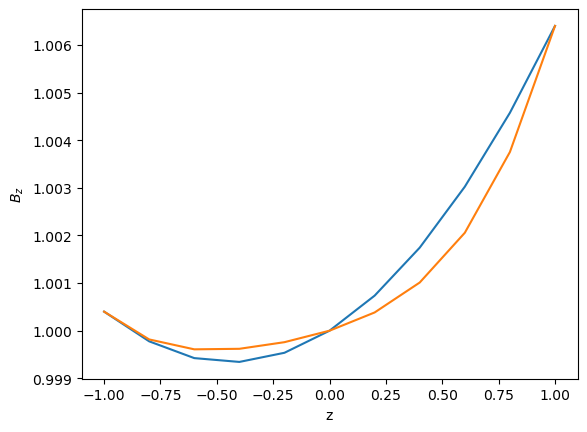

In [12]:
# plot Bz (predicted/actual) vs z
plt.plot(z_coords[:,2],B_z[:,2])
plt.plot(z_coords[:,2],Bv_pred[:,2])
plt.xlabel('z')
plt.ylabel('$B_z$')

Text(0, 0.5, '$B_y$')

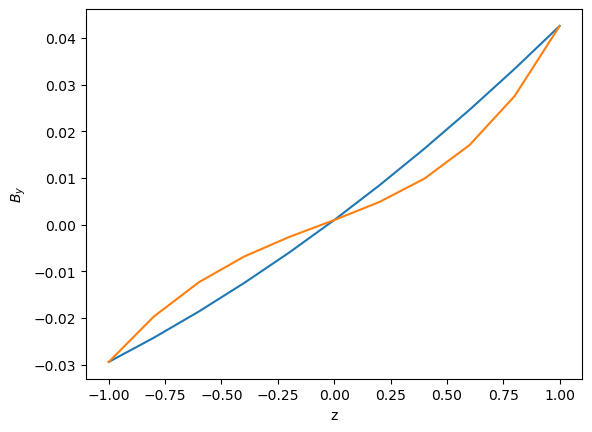

In [13]:
# plot By (predicted/actual) vs z
plt.plot(z_coords[:,2],B_z[:,1])
plt.plot(z_coords[:,2],Bv_pred[:,1])
plt.xlabel('z')
plt.ylabel('$B_y$')

Text(0, 0.5, '$B_x$')

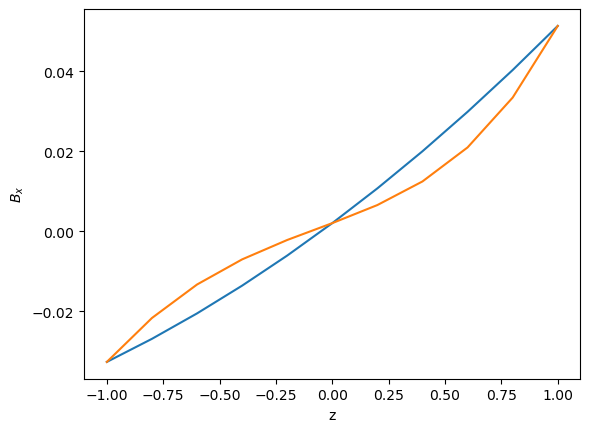

In [14]:
# plot Bx (predicted/actual) vs z
plt.plot(z_coords[:,2],B_z[:,0])
plt.plot(z_coords[:,2],Bv_pred[:,0])
plt.xlabel('z')
plt.ylabel('$B_x$')